<a href="https://colab.research.google.com/github/Mlad-en/causal_data/blob/main/Falsified_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Data Science Project

Data from Card (1995) to estimate the effect of college education on earnings



In [1]:
pip install dowhy

Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of Education on wages
.

We can start by identifying the descendants of Education, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of education are: eduaction and wages.

We now consider every backdoor path from education to wages, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy.

In [2]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

In [3]:
import pandas as pd

Then, we create an undirected copy of our graph and call it $H$ so we can find all possible undirected paths between education and wages
.

Finally, we can use the `is_backdoor` method of a `Backdoor` instance to check which of these paths are backdoor paths.

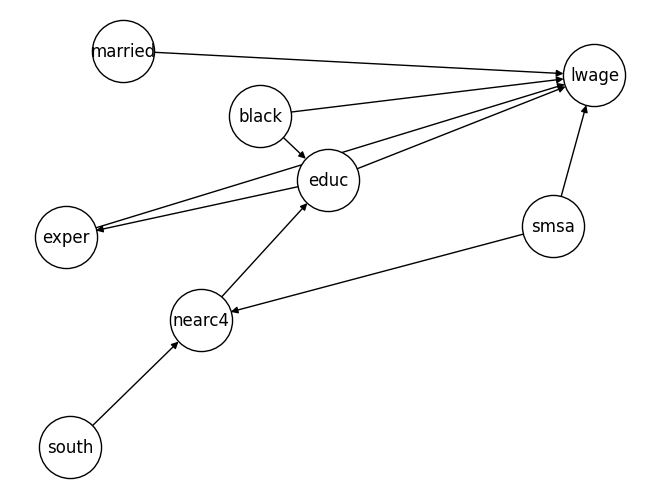

In [4]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(["lwage", "educ", "exper", "black", "south", "married", "smsa", "nearc4"])

G.add_edges_from([
    ("educ", "lwage"), ("exper", "lwage"),
    ("black", "lwage"), ("married", "lwage"),
    ("nearc4", "educ"),
    ("black", "educ"), ("south", "nearc4"), ("smsa", "nearc4"), ("smsa", "lwage"), ("educ", "exper")
])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear)
# and save it to a .gml format (for using DoWhy later)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos= pos, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [5]:
# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [6]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'educ', 'lwage'))
for path in all_possible_paths:
    print(path)

['educ', 'lwage']
['educ', 'exper', 'lwage']
['educ', 'black', 'lwage']
['educ', 'nearc4', 'smsa', 'lwage']


In [7]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'educ', 'lwage')

In [8]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['educ', 'black', 'lwage']
['educ', 'nearc4', 'smsa', 'lwage']


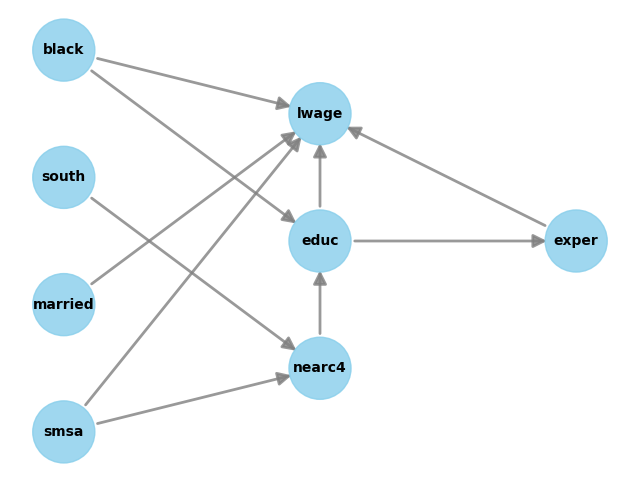

In [9]:
import pandas as pd
import dowhy
from dowhy import CausalModel

# creating arbitrary data
df = pd.DataFrame({'lwage':[1],'educ':[1],'exper':[1],'black':[1],'south':[1],'married':[1],
                  'smsa': [1], 'nearc4': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
    data = df,
    treatment='nearc4',
    outcome='lwage',
    graph=gml_graph
)
model.view_model()

In [10]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[lwage|smsa])
d[nearc₄]               
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,smsa,U) = P(lwage|nearc4,smsa)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                    -1⎤
 ⎢   d            ⎛   d              ⎞  ⎥
E⎢────────(lwage)⋅⎜────────([nearc₄])⎟  ⎥
 ⎣d[south]        ⎝d[south]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→lwage then ¬(U →→{south})
Estimand assumption 2, Exclusion: If we remove {south}→{nearc4}, then ¬({south}→lwage)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



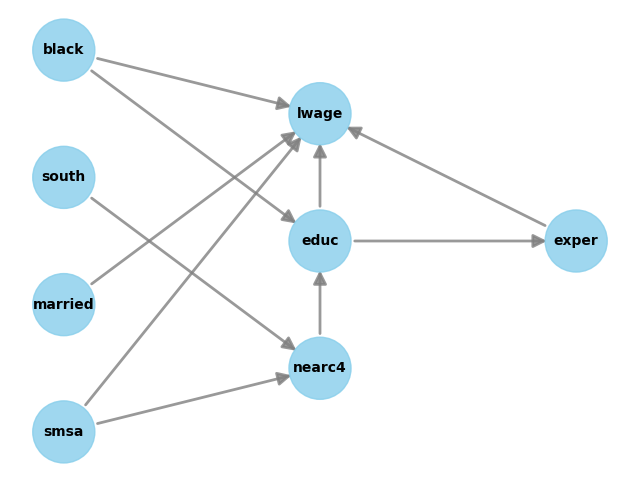

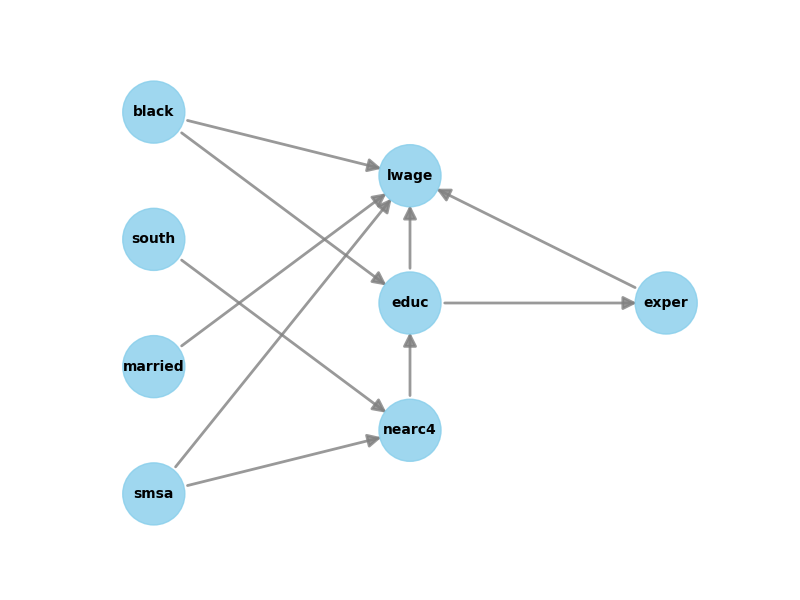

In [11]:
import dowhy
import pandas as pd
from dowhy import CausalModel

# once again we use arbitrary data, since we are still focused on the graph and not data
df = pd.DataFrame({'lwage':[1],'educ':[1],'exper':[1],'black':[1],'south':[1],'married':[1],
                  'smsa': [1], 'nearc4': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='nearc4',
        outcome='lwage',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[lwage|smsa])
d[nearc₄]               
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,smsa,U) = P(lwage|nearc4,smsa)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                    -1⎤
 ⎢   d            ⎛   d              ⎞  ⎥
E⎢────────(lwage)⋅⎜────────([nearc₄])⎟  ⎥
 ⎣d[south]        ⎝d[south]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→lwage then ¬(U →→{south})
Estimand assumption 2, Exclusion: If we remove {south}→{nearc4}, then ¬({south}→lwage)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### week4

In [13]:
from google.colab import drive
import torch
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Academic English Assignment 2 .gdoc'
'Advanced Programming.gdoc'
'AML PROJECT'
'Analysing the introduction (1)-1.gdoc'
'Analysing the introduction (1)-1.pages'
'Assignment 1  Business Simulation.gdoc'
'Assignment 2 Business simulation.gdoc'
'Assignment 3 Business Simulation.gdoc'
'Assignment 4 Business Simulation.gdoc'
'Assignment 7.gdoc'
'Assignment A.gdoc'
'Assignment self-reflection.gdoc'
'Assignment week 5.gdoc'
 Big_Data_G_18
'Big Data.gdoc'
 Brief.gdoc
'Bullet Point draft.gdoc'
'Caroliens stomme debat.gdoc'
 Casual_data.ipynb
 causal_model.png
'Character development essay.gdoc'
 Character-Development-Worksheet.pdf
'Checklist FINAL version INTRODUCTION Moves123-2.gdoc'
'Checklist FINAL version INTRODUCTION Moves123-2.pdf'
 close_college.dta
'Cohesion exercise table-session 3.gdoc'
'Colab Notebooks'
 Combined_data.pkl
'Consultancyvoorstel (1).gslides'
 C

In [14]:
close_college = pd.read_stata('close_college.dta')

In [15]:
close_college

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674
...,...,...,...,...,...,...,...,...
3005,1,12,0,0,1,1.0,7,5.814130
3006,1,13,0,1,1,1.0,15,6.175867
3007,1,12,0,0,1,1.0,6,6.214608
3008,1,12,0,0,1,1.0,13,6.569481


In [16]:
close_college= close_college.fillna(0)

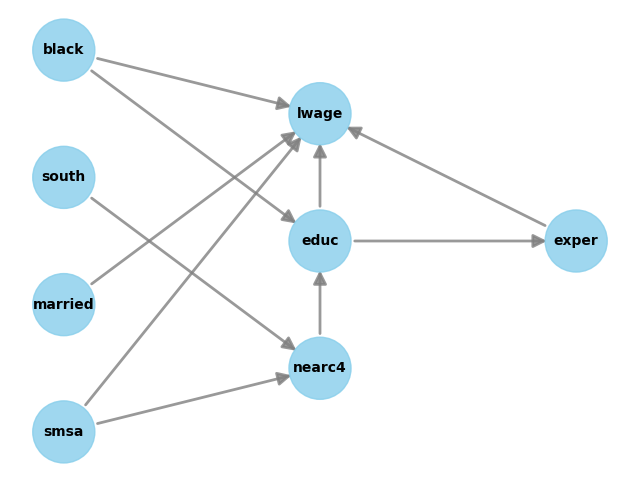

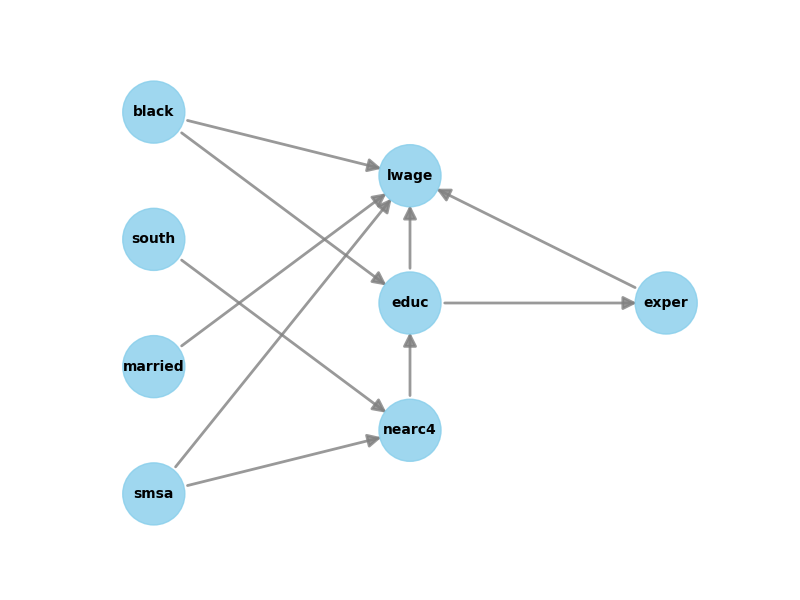

In [17]:
# we use the data and the graph it is generated from to create a CausalModel object
model=CausalModel(
        data = close_college,
        treatment="nearc4",
        outcome="lwage",
        graph=gml_graph
        )

model.view_model()
display(Image(filename="causal_model.png"))

We will not manually apply the backdoor criterion, frontdoor criterion, or instrumental variables; instead, we will simply use the valid adjustment sets found by DoWhy. We see that there are no sets satisfying the frontdoor criterion, but there are for the backdoor and instrumental variables. You can check yourself that these satisfy the criteria.

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[lwage|smsa])
d[nearc₄]               
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,smsa,U) = P(lwage|nearc4,smsa)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                    -1⎤
 ⎢   d            ⎛   d              ⎞  ⎥
E⎢────────(lwage)⋅⎜────────([nearc₄])⎟  ⎥
 ⎣d[south]        ⎝d[south]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→lwage then ¬(U →→{south})
Estimand assumption 2, Exclusion: If we remove {south}→{nearc4}, then ¬({south}→lwage)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Let's use the set identified by the backdoor criterion. We can thus estimate the effect of nearc4 on lwage when we condition on south, smsa, black.

Let's first try estimate the effect without conditioning on these extra variables. Suppose we expect (know) that the effect is linear. We can then apply a linear estimator to find the effect. We will use linear regression.

In [19]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
nearc4_vals = close_college['nearc4'].values.reshape(3010, 1)
lwage_vals = close_college['lwage'].values.reshape(3010, 1)

In [20]:
# we import the LinearRegression object from sklearn
from sklearn.linear_model import LinearRegression

# we fit a linear regression model with v0 and y, and check what the estimated linear effect is
linear_regressor = LinearRegression()
linear_regressor.fit(nearc4_vals, lwage_vals)
linear_regressor.coef_

array([[0.15590747]])

We see that the estimated linear effect is highly biased, but we expected this knowing we needed to condition on the correct sets. Let's try conditioning on only part of a valid adjustment set.


We see that our estimate (the first coeffcient) is still biased. Now, we try using the correct conditioning set.

In [21]:
import numpy as np
smsa_vals = close_college['smsa'].values.reshape(3010, 1)
backdoor_vars = np.concatenate((nearc4_vals, smsa_vals), axis = 1)
backdoor_vars

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

In [22]:
linear_regressor.fit(backdoor_vars, lwage_vals)
linear_regressor.coef_

array([[0.08782307, 0.19813143]])

Now our estimate (the first coefficient) is unbiased. So we would thus correctly conclude that our linear causal effect is 10.

DoWhy allows you to estimate causal effects using different estimators based on the adjustment sets it identifies. We can do what we did above by calling the estimate_effect function on our identified_estimand and specifying which criterion we wish to use, and which estimator. The different estimators you can use are available here: https://github.com/microsoft/dowhy/tree/master/dowhy/causal_estimators. When calling the estimator, exclude the '_estimator' at the end.

Below, we specify we want to use the adjustment set from the backdoor criterion and a linear regression estimator.

In [23]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[lwage|smsa])
d[nearc₄]               
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,smsa,U) = P(lwage|nearc4,smsa)

## Realized estimand
b: lwage~nearc4+smsa+nearc4*black+nearc4*married
Target units: 

## Estimate
Mean value: 0.07593496427617996
### Conditional Estimates
__categorical__black  __categorical__married
(-0.001, 1.0]         (-0.001, 1.0]             0.142385
                      (1.0, 5.0]               -0.049277
                      (5.0, 6.0]               -0.109750
dtype: float64
Causal Estimate is 0.07593496427617996


In [24]:
# using the backdoor adjustment set and propensity score stratification
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[lwage|smsa])
d[nearc₄]               
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,smsa,U) = P(lwage|nearc4,smsa)

## Realized estimand
b: lwage~nearc4+smsa
Target units: ate

## Estimate
Mean value: 0.085241103762389

Causal Estimate is 0.085241103762389


Finally, there are a number of techniques we can apply to test whether the estimate is accurate when adding in noise, downsampling, etc.

In [25]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:0.085241103762389
New effect:0.085241103762389
p value:1.0



Here we've added a random common cause, and it has not significantly affected our estimate. This gives us more confidence in our estimate. There are numerous other refutation techniques available in DoWhy.


In [26]:
refute_placebo_treatment = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )

print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:0.085241103762389
New effect:0.00023673319622373424
p value:0.94



In [27]:
bootstrap_refuter = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="bootstrap_refuter",
    num_simulations=100 # Number of bootstrap samples to create
)
print(bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:0.085241103762389
New effect:0.08674679406999104
p value:0.98



In [28]:
# using the instrumental variables
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                    -1⎤
 ⎢   d            ⎛   d              ⎞  ⎥
E⎢────────(lwage)⋅⎜────────([nearc₄])⎟  ⎥
 ⎣d[south]        ⎝d[south]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→lwage then ¬(U →→{south})
Estimand assumption 2, Exclusion: If we remove {south}→{nearc4}, then ¬({south}→lwage)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡  d          ⎤  -1⎡  d           ⎤
E⎢──────(lwage)⎥⋅E  ⎢──────(nearc₄)⎥
 ⎣dsouth       ⎦    ⎣dsouth        ⎦
Estimand assumption 1, As-if-random: If U→→lwage then ¬(U →→{south})
Estimand assumption 2, Exclusion: If we remove {south}→{nearc4}, then ¬({south}→lwage)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['nearc4'] is affected in the same way by common ca

Not every estimator will always give a good estimate. This depends on the true nature of the effect (linear, exponential, etc.), and the assumptions made by the estimator. We can do this one correctly using the IV notebook shown by Sara in class which implements 2SLS.


In [29]:
# we define a function to extract our linear regression coefficient
def linear_coeff(X,Y):
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    return linear_regressor.coef_

In [30]:
# we reshape the variables we are going to use (Z1 is a sufficient instrumental variable)
v0 = close_college['nearc4'].values.reshape(-1,1)
z1 = close_college['south'].values.reshape(-1,1)
y = close_college['lwage'].values.reshape(-1,1)

In [31]:
# we can calculate the linear effect that Z1 has on v0, and what our estimated linear v0 values are
vhat = linear_coeff(z1, v0) * z1

In [32]:
# we can finally calculate the linear effect of vhat on y
linear_coeff(vhat, y)

array([[1.21713391]])

In [33]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:1.2171329716897357
New effect:1.2171329716897359
p value:1.0



In [34]:
refute_placebo_treatment = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )

print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:1.2171329716897357
New effect:0.0016396003899901133
p value:0.98



In [35]:
bootstrap_refuter = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="bootstrap_refuter",
    num_simulations=100 # Number of bootstrap samples to create
)
print(bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:1.2171329716897357
New effect:1.2290860790440628
p value:0.9199999999999999

